# AESA/PESA Radar Simulation Demo

This demonstration simulates data from a **Doppler radar** and, eventually, a **PESA radar**.  
The goal is to use machine learning to estimate:

- **Location**
- **Speed**
- **Distance** of a target

While this approach is slower than mathematical solutions, it aims to provide an *open-source* alternative that is transparent and accessible.

## Purpose

- Assist in developing small radar systems to protect tanks/IFVs.
- Address threats like drones cost-effectively.
- Enable processing with a small computer and radar installation.

*Prototype development will follow later.*

In [ ]:
#!/usr/bin/env python3
# Imports 
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import random, math
from scipy.signal import hilbert
from scipy.fft import fft, fftfreq


we store our freuqencies within a hashmap as tuples to be able to more finely constrain wavelength

In [3]:
frequency_bands = {
    "L":  (1e9, 2e9),        # 1 – 2 GHz
    "S":  (2e9, 4e9),        # 2 – 4 GHz
    "C":  (4e9, 8e9),        # 4 – 8 GHz
    "X":  (8e9, 12e9),       # 8 – 12 GHz
    "Ku": (12e9, 18e9),      # 12 – 18 GHz
    "Ka": (26.5e9, 40e9)     # 26.5 – 40 GHz
}

def getFrequency(frequencyBand: str) -> float:
    if frequencyBand in frequency_bands:
        f_min, f_max = frequency_bands[frequencyBand]
        return random.uniform(f_min, f_max)
    else:
        raise ValueError("unknown frequency band")


#### Create our dataclasses for the radar
- a basic target and radar MVP for our caluclations


In [4]:
# --- Target struct---
@dataclass
class Target:
    name: str             # Target name - e.g. "SU-33"
    classification: str   # e.g. "drone/aircraft/helicopter"
    position: np.ndarray  # [x, y, z] meters
    rcs: float            # Radar cross-section (sigma)
    velocity: np.ndarray = np.array([0.0, 0.0, 0.0])  # m/s

# --- Radar struct---
@dataclass
class Radar:
    name: str                # Radar name (brand)
    position: np.ndarray       # Radar position [x, y, z]
    frequency: float           # Radar frequency (Hz)
    transmitted_power: float   # Transmit power (W)
    antenna_gain: float        # Antenna gain (linear)

    def get_elucidianDistance(self, target: Target) -> float:
        """Calculate elucid distance between radar and target using numpy linear algebra"""
        return np.linalg.norm(target.position - self.position) 
    
    def getTimeDelay(self, target: Target) -> float:
        """Calculate time delay for signal to travel to target and back (delta T)"""
        c = 3e8
        return 2 * self.get_elucidianDistance(target) / c
    
    def getRecievedPower(self, target: Target) -> float:
        """Calculate the received power using the radar equation"""
        c = 3e8 # speed of light
        Pt = self.transmitted_power
        G = self.antenna_gain
        lambda_ =  c / self.frequency
        sigma = target.rcs
        R = self.get_elucidianDistance(target)
        L = 1 # System losses (assumed to be 1 for simplicity)
        return (Pt * G**2 * lambda_**2 * sigma) / ((4 * math.pi)**3 * R**4 * L)
    
    def simulate_ping(self, target: Target, duration=1e-4, sample_rate=1e7, noise_power=1e-10):
        t = np.arange(0, duration, 1/sample_rate)
        c = 3e8
        f_c = self.frequency
        
        # Line-of-sight velocity
        R_vec = target.position - self.position
        R_hat = R_vec / np.linalg.norm(R_vec)
        v_los = np.dot(target.velocity, R_hat)  # m/s along line-of-sight
        
        # Doppler shift
        lambda_ = c / f_c
        f_D = 2 * v_los / lambda_
        
        # Time delay
        delay = self.getTimeDelay(target)
        
        # Received power
        Pr = self.getRecievedPower(target)
        
        # Short pulse echo
        pulse_duration = 1e-6
        pulse_mask = np.abs(t - delay) < (pulse_duration / 2)
        echo = np.zeros_like(t)
        echo[pulse_mask] = np.sqrt(Pr) * np.cos(2 * np.pi * (f_c + f_D) * (t[pulse_mask] - delay))
        
        # Add noise
        noise = np.random.normal(0, np.sqrt(noise_power), size=t.shape)
        
        received_signal = echo + noise
        return t, received_signal



### Creating our radar and target 
#### Here we create our radar and target variables, we are using data referenced from wikipedia at 
*https://en.wikipedia.org/wiki/AN/SPY-1*

In [5]:
radar = Radar(
    name="AN/SPY-1",
    position=np.array([0, 0, 0]),   # Radar at origin (x=0, y=0, z=0)
    frequency=getFrequency("S"),    # Use the key from frequency_bands
    transmitted_power=4e6,          # 4 MW (peak power)
    antenna_gain=10**(42/10)        # Convert dB to linear scale
)

target = Target(
    name="SU-33",
    classification="aircraft",
    position=np.array([6000, 0, 0]),  # 6 km in front of origin (x=0, y=0, z=0)
    rcs=10.0,                         # Example RCS in m² (fighter-sized target)
    velocity=np.array([600, 0, 0])    # 600 m/s along x-axis (approx 900 km/h
)


# Basic PD range estimation (without doppler shift)

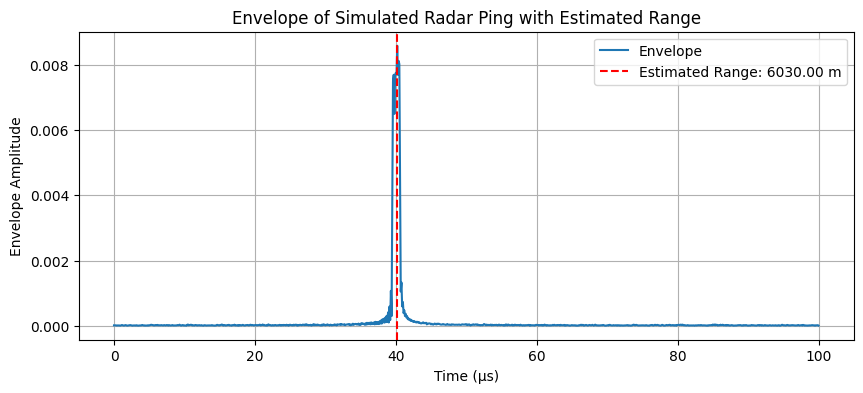

In [6]:
# Simulate radar ping
t, received_signal = radar.simulate_ping(
    target,
    duration=1e-4, 
    sample_rate=1e7, 
    noise_power=1e-10
)

# Compute the envelope using the Hilbert transform
analytic_signal = hilbert(received_signal)
envelope = np.abs(analytic_signal)

# Find the peak of the envelope
peak_idx = np.argmax(envelope)
t_peak = t[peak_idx]  # seconds

# Convert time to range
c = 3e8  # speed of light in m/s

# Minimum range to start looking for targets
min_range = 1  # skip first 100 meters
min_idx = int((2 * min_range / c) * 1e7)  # convert time to index, sample_rate = 1e7 Hz

# Find peak after the minimum index
peak_idx = np.argmax(envelope[min_idx:]) + min_idx
t_peak = t[peak_idx]
target_range = c * t_peak / 2

# Plot the envelope and mark estimated range
plt.figure(figsize=(10,4))
plt.plot(t*1e6, envelope, label='Envelope')
plt.axvline(t_peak*1e6, color='r', linestyle='--', 
            label=f'Estimated Range: {target_range:.2f} m')
plt.xlabel("Time (µs)")
plt.ylabel("Envelope Amplitude")
plt.title("Envelope of Simulated Radar Ping with Estimated Range")
plt.grid(True)
plt.legend()
plt.show()